# Analyze MCE data taken on TmVO4 samples
either in DR (plate-like sample) or in He3 (needles)

In [1]:
# Standard Python libraries
import csv, glob, os, re, sys, time
from datetime import date
from importlib import reload
from pathlib import Path
from warnings import warn

# Data analysis libraries
import numpy as np
from numpy.polynomial.polynomial import polyval2d
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import LinearNDInterpolator

# Plotting libraries
%matplotlib
from matplotlib import pyplot as plt, cm, rcsetup, rc, rcParams
from mplcursors import cursor
# cm stands for colormap

# Fitting libraries
from lmfit import minimize, Model, Parameters, report_fit, fit_report
from lmfit.models import LinearModel

Using matplotlib backend: Qt5Agg


In [2]:
# Create today's date variables
today = date.today()
this_month = str(today)[:-3]

In [3]:
# Define sample parameters 
# He3 sample is TmVO4-LS5200-needles, DR sample is TmVO4-LS5228-DR-HC1807
mfd_dir = {'LS5200':r'C:\Users\Pierre\Desktop\Postdoc\Software\COMSOL\TmVO4-LS5200_HC2017-07\TmVO4-LS5200_HC2017-07_COMSOL_results',
           'LS5228':r'C:\Users\Pierre\Desktop\Postdoc\Software\COMSOL\TmVO4-LS5228-DR-HC1807'}

mfdFname = {'LS5200':['2020-11-03_TmVO4-LS5200_HC17-VII_T=p3-p4-3p1_Hext=all.csv'], 
            'LS5228':['2021-02-11_TmVO4-LS5228-DR-HC1807_Hz_Hc=5kOe_Hext=2-10kOe_T=p1-3p1K.csv']}

# Choose which sample to work with
sample = 'LS5228'

## Comsol magnetic field distribution

In [4]:
# Change to directory containing MFD data
os.chdir(mfd_dir[sample])

In [5]:
#%% Import magnetic field distribution from CSV file
# mfdNdlFname = ['2020-11-03_TmVO4-LS5200_HC17-VII_T=p3-p4-3p1_Hext=all.csv']
for elmt in ['header', 'mfd_list', 'Hext_list', 'Tmfd_list']:
    exec(f'{elmt} = []')
mfd = {}

for fname in mfdFname[sample]:
    with open(fname, newline='') as f:
        reader = csv.reader(f)
        for _ in range(9):
            row = next(reader)  # gets the first line
        for idx in range(len(row)):
            if 'mfnc' in row[idx]:
                header.append(','.join([row[idx], row[idx+1]]))
                mh = re.match('.*@ (\d+): (\wext)=(\d[\.\d]+) \w+, T=(\d\.\d) K', header[-1])
                mfd_idx = int(mh.group(1))
                if mh.group(2)=='Bext':
                    Hext = float(mh.group(3))*1e4
                elif mh.group(2)=='Hext':
                    Hext = float(mh.group(3))
                Tmfd = float(mh.group(4))
                mfd_key = (Hext, Tmfd)
                mfd[mfd_key] = {}
                Hext_list.append(Hext)
                Tmfd_list.append(Tmfd)
                # Read MFD data from csv file:
                # Use last string in header as column header
                # Read data from column mfd_idx+2 since, the 3 first columns are x, y, z data
                # squeeze=True in order to make it a Series instead of a DataFrame, since there is only one column for each mfd_idx
                mfd[mfd_key]['data'] = pd.read_csv(fname, comment='%', 
                                                   names=[header[-1]], 
                                                   usecols=[mfd_idx+2],
                                                   squeeze=True)
                # If all elements of an MFD are NaN, delete the corresponding entry
                if mfd[mfd_key]['data'].isna().all():
                    del mfd[mfd_key]
            # elif and else are only for debugging purposes
            elif 'T=' in row[idx]: continue
            else: header.append(row[idx])
uhext = np.unique(Hext_list)
utmfd = np.unique(Tmfd_list)
mfd[mfd_key]['data']# 

0         0.78143
1         0.78143
2         0.78143
3         0.87819
4         0.87819
           ...   
153779    0.84014
153780    0.84014
153781    0.84014
153782    0.84014
153783    0.84014
Name: mfnc.Hz/Hext (1) @ 56: Hext=10000 Oe, T=3.1 K, Length: 153784, dtype: float64

In [6]:
plt.figure()
plt.plot(mfd[mfd_key]['data'])

In [7]:
# Function to find relative width of a distribution
def mfd_rel_width(mfd_data, Href):
    # purge distribution from non-zero values 
    # useful for datasets computed in a box bigger than Comsol model
    # and to ignore NaN data
    real_data = mfd_data[mfd_data>0]/Href# normalize wrt Hc or Hext

    # Find relative value of mfd that is furthest away from 1
    if abs(1-min(real_data))>abs(1-max(real_data)): 
        relative_width = abs(1-min(real_data))
    else: 
        relative_width = abs(1-max(real_data))

    return relative_width

In [8]:
# Function to create histogram from MFD data
def mfd_histogram(mfd_data, Href, nbins=75):
    # purge distribution from non-zero values 
    # useful for datasets computed in a box bigger than Comsol model
    # and to ignore NaN data
    real_data = mfd_data[mfd_data>0]/Href# normalize wrt Hc or Hext

    # Find relative value of mfd that is furthest away from 1, 
    # so as to define the histogram range base on this value
    # This allows to create a symmetric histogram, which is useful for later convolution
    half_range = mfd_rel_width(mfd_data, Href)
        
    # compute histogram of distribution
    hist_counts, edges = np.histogram(real_data, bins=nbins, 
                                      range=(1-half_range, 1+half_range),
                                      density=True)
    bin_centers = np.mean([edges[:-1], edges[1:]], 0)
    bin_widths = edges[1:]-edges[:-1]

    return hist_counts, bin_centers, bin_widths

In [9]:
#%% Compute probability distribution of fields at a given value of T and Hext
for key in mfd.keys():
    if sample=='LS5200':
        Hext = key[0]
    elif sample=='LS5228':
        Hext = 1
#     Tmfd = key[1]
    # Compute mfd histogram and unpack it into into dictionary key
    mfd[key]['rel_width'] = mfd_rel_width(mfd[key]['data'], Hext)
    mfd[key]['hc'], mfd[key]['binCenters'], mfd[key]['binWidths'] = \
    mfd_histogram(mfd[key]['data'], Hext, nbins=75)

In [10]:
#%% Plot distribution of fields at a given value of T and Hext
fig, ax = plt.subplots()

plt_keys = {'fixed T': [(uhext[i], utmfd[2])  for i in [0, 2, 4, 6]],
           'fixed H': [(uhext[2], utmfd[i]) for i in [0, 2, 3, 5]]}
# param_index = 1# 0 is constant T, 1 is constant Hext, see param_range
# param_range = [, [i+4*8 for i in [1,3,5,7]]]# first range corresponds to a 
# # field dependence at constant temp, second range corresponds to a 
# # temperature dependence at constant field
# # rng = param_range[param_index]#
Hc = 5e3
Tc = 2.2 
setting = 'fixed H'

if setting=='fixed T':
    fixedp = Tmfd = plt_keys[setting][0][1]
    varp_idx = 0
    pc = Hc
    lgd_title = '$H_{\mathrm{ext}}/H_c$'
    ann_str = f'$T/T_c=$ {Tmfd/Tc:.2g}'
elif setting=='fixed H':
    fixedp = Hext = plt_keys[setting][0][0]
    varp_idx = 1
    pc = Tc
    lgd_title = '$T/T_c$'
    ann_str = ''.join('$H_{\mathrm{ext}} =$' f' {Hext/1e3:.3g} kOe')

for key in plt_keys[setting]:
#     if param_index==0: lgd_str = f'{Hext/Hc:.2g}'
#     elif param_index==1: lgd_str = f'{Tndl/Tc:.2g}'
    lgd_str = f'{key[varp_idx]/pc:.2g}'
    p = plt.plot(mfd[key]['binCenters'], mfd[key]['hc'], '.-', label=lgd_str)
# plt.xlim([.6966,1.05])

lgd = plt.legend(title=lgd_title) 
anndist = plt.annotate(ann_str, xy=(.35, .85), xycoords='axes fraction', 
                       bbox=dict(boxstyle='round', fc='w'))# add annotation
# needle_title = 'Field distribution in TmVO$_4$ needles'
# param_title = [f', $T=$ {Tndl:%.2g} K', f', $H_{\mathrm{ext}}=$ {Hext:%.2d} Oe']
# title(''.join([needle_title, param_title[param_index]])
plt.xlabel('$H_{\mathrm{in}}/H_{\mathrm{ext}}$')
plt.ylabel('Probability density')
# plt.xticks = np.arange(.7, 1, .1)
plt.grid(b=True)
cursor()

In [11]:
#%% Compute the average value of ratio of internal to external magnetic field 
for key in mfd.keys():
    mfd[key]['Hinm_Oe'] = np.round(
        np.sum(
        mfd[key]['binCenters']*mfd[key]['hc']*mfd[key]['binWidths']
        )*key[0]
        )

In [12]:
#%% Check results for given range of temperatures/field

# Check that the ratio of Hinm/Hext is roughly constant inside the
# ordered phase, thus allowing to use the value at 0.3 K and 1000 Oe as a proxy
for elmt in ['h', 'Hinm', 'Hext', 'Tmfd']:
    exec(f'{elmt}=[]')# initialize lists
    
for key in plt_keys[setting]:
    Tmfd.append(key[1])
    Hext.append(key[0])
    Hinm.append(mfd[key]['Hinm_Oe'])
    h.append(mfd[key]['Hinm_Oe']/key[0])

# rescaling factor, due to demag; take value at H~Hc and T~Tc/2, which is where the MCE data is interesting
# rescaling = mfd[list(mfd)[-6]]['Hinm_Oe']/list(mfd)[-6][0]# used for LS5200 prior to adapting code for LS5228
Href = np.unique(Hext_list)[np.argmin(abs(np.unique(Hext_list)-5000))]
Tref = np.unique(Tmfd_list)[np.argmin(abs(np.unique(Tmfd_list)-.5))]
rescaling = mfd[(Href,Tref)]['Hinm_Oe']/Href#
rescaling

0.9246

## Importation of MCE data 

In [13]:
datFilePath = {'LS5200':r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2017-07_TmVO4_Cp_MCE\2017-07-28--31\Massaic_MCE',
               'LS5228':r'C:\Users\Pierre\Desktop\Postdoc\TmVO4\TmVO4_heat-capacity\2018-08_TmVO4-LS5228'}
os.chdir(datFilePath[sample])

datafiles = {'LS5200':[f'Run{runID}_*.dat' for runID in range(2,8)],
            'LS5228':['2018-08-01_MCE_TmVO4-LS5228-DR-HC180731.dat']}

In [14]:
# Initialize dictionaries that will contain data for each run
for key in ['dataset', 'run_date', 'I', 'R', 'H', 'T', 'Tpuck', \
            'Hi', 'Ti', 'Tpucki', 'dHi','dH', 'dT', 'd1T', 'd2T',\
            'mce_sim', 'mce_fit', 'refsweep', 'usr', 'utbath', 'sweeprates']:
    if key not in locals():
        exec(f'{key}={{}}')

In [15]:
runIDs_all = []
for runID in range(len(datafiles[sample])):
    file_str = glob.glob(datafiles[sample][runID])[0]
    runIDs_all.append(runID)# int(m.group(1)) also works
    if sample=='LS5200':
        m = re.match('Run(\d)_(0p\d).*', file_str)
        I[runID] = float(m.group(2).replace('p','.'))*1e-6# input current, in amps
        dataset[runID] = pd.read_csv(file_str, sep=', ', engine='python')
    elif sample=='LS5228':
        dataset[runID] = pd.read_csv(file_str, sep=',', header=30, engine='python')
        for col in dataset[runID].columns:
            if dataset[runID][col].isna().all():# if a column doesn't contain any data
                dataset[runID].drop(columns=[col], inplace=True)# remove it

print(dataset[runID])

       Time Stamp (sec)  Temperature (K)  Magnetic Field (Oe)  \
0          1.843488e+07         0.974414            57.876705   
1          1.843488e+07         0.949551           121.954155   
2          1.843489e+07         0.960359           185.022614   
3          1.843490e+07         0.990504           248.921677   
4          1.843490e+07         1.007351           311.943329   
...                 ...              ...                  ...   
23608      1.852809e+07         1.700876          3000.310547   
23609      1.852810e+07         1.700578          3000.310547   
23610      1.852810e+07         1.700987          3000.298584   
23611      1.852810e+07         1.700844          3000.322754   
23612      1.852810e+07         1.700840          3000.322754   

       Sample Position (degrees)  Bridge 1 Resistivity (Ohm-m)  \
0                  -1.703913e+38                           NaN   
1                  -1.703913e+38                           NaN   
2                  -1

In [16]:
dataset[0].columns

Index(['Time Stamp (sec)', 'Temperature (K)', 'Magnetic Field (Oe)',
       'Sample Position (degrees)', 'Bridge 1 Resistivity (Ohm-m)',
       'Bridge 1 Excitation (uA)', 'Bridge 2 Resistivity (Ohm-m)',
       'Bridge 2 Excitation (uA)', 'Bridge 1 Std. Dev. (Ohm-m)',
       'Bridge 2 Std. Dev. (Ohm-m)', 'Number of Readings',
       'Bridge 1 Resistance (Ohms)', 'Bridge 2 Resistance (Ohms)'],
      dtype='object')

## Conversion of MCE resistance data to temperature 
using fits of 1/T vs R curves across values of magnetic field and input current

### Reproducing betamodel.mat
Which is the surface fit used in Matlab to convert the platform resistance data of the lockin to inverse temperature data:
$$ 1/T = \mathrm{betamodel}(V_X) $$

In [17]:
# The content of this cell was copy-pasted from the content of the 
# BetaModel sfit variable, as shown in Matlab after importing betamodel.mat

# Coefficients (with 95% confidence bounds):
p00 =     -0.2734#  (-0.2752, -0.2716)
p10 =    9.78e-06#  (8.802e-06, 1.076e-05)
p01 =      0.0011#  (0.001096, 0.001104)
p20 =   -4.45e-09#  (-5.037e-09, -3.862e-09)
p11 =  -1.322e-08#  (-1.427e-08, -1.216e-08)
p02 =  -2.275e-07#  (-2.305e-07, -2.246e-07)
p30 =   9.561e-13#  (7.765e-13, 1.136e-12)
p21 =   3.565e-12#  (3.342e-12, 3.789e-12)
p12 =   4.659e-12#  (4.225e-12, 5.092e-12)
p03 =    3.37e-11#  (3.272e-11, 3.468e-11)
p40 =  -8.502e-17#  (-1.093e-16, -6.072e-17)
p31 =  -6.191e-16#  (-6.464e-16, -5.918e-16)
p22 =   8.508e-17#  (4.041e-17, 1.298e-16)
p13 =  -6.088e-16#  (-6.86e-16, -5.316e-16)
p04 =  -2.724e-15#  (-2.872e-15, -2.577e-15)
p50 =   2.293e-21#  (1.105e-21, 3.48e-21)
p41 =   3.892e-20#  (3.749e-20, 4.034e-20)
p32 =   -1.77e-20#  (-1.973e-20, -1.567e-20)
p23 =   1.698e-21#  (-1.673e-21, 5.069e-21)
p14 =   2.632e-20#  (2.116e-20, 3.148e-20)
p05 =   8.741e-20#  (7.917e-20, 9.565e-20)

# Linear model Poly55:
def betamodel(x,y):
    """
    x: array
        Magnetic field data.
    y: array
        Platform resistance data.
    """
    val = p00 + p10*x + p01*y + p20*x**2 + p11*x*y + p02*y**2 + p30*x**3 +\
    p21*x**2*y + p12*x*y**2 + p03*y**3 + p40*x**4 + p31*x**3*y \
    + p22*x**2*y**2 + p13*x*y**3 + p04*y**4 + p50*x**5 + p41*x**4*y \
    + p32*x**3*y**2 + p23*x**2*y**3 + p14*x*y**4 + p05*y**5
    return val

### Improved R-T conversion scheme
Instead of fitting resistance data stored in the .raw files of Cp measurements, which is what the betamodel function did, fit resistance data directly from the calibration file. This is more accurate for two reasons:
1. There are way more datapoints in the calibration file then in the .raw files of Cp measurements, and they are not redundent
2. The .raw files of Cp measurements use an approximation of the R vs T data taken from the calibration file. Fitting data from the .raw files therefore introduces an extra step (with an extra approximation) in the conversion of data

In [18]:
os.chdir(r'C:\Users\Pierre\Desktop\Postdoc\Technical_stuff\PPMS\PPMS_Heat_capacity\PPMS_Heat-capacity_TempCal')

calname = {'LS5200':'./He3_TempCal/2021-01-15_He3Puck698_multicurve_all_currents.dat',
           'LS5228':'./DR_TempCal/2021-02-02_DR_Tempcal_FisherPPMS/2021-02-02_DRPuck167_multicurve_all_currents.dat'}

calhardware = {'LS5200':'DSP',
               'LS5228':'CAN'}

In [19]:
# Read MFD data from csv file:
# Use last string in header as column header
# Read data from column mfd_idx+2 since, the 3 first columns are x, y, z data
# squeeze=True in order to make it a Series instead of a DataFrame, since there is only one column for each mfd_idx
cal = pd.read_csv(calname[sample], skiprows=7, header=0)
cal

,Temperature (K),Current (code),Active Current Code,Field (Oe),ThRes (ohms),slope of -R vs T (ohms/K),slope of -R vs T (%/K),Point-to-Point R change (ohms),Point-to-Point slope change (ohms/K),Delta R in Overlap (ohms),Delta R in Overlap (%)
0,0.050008,21,21,0.00000,18789.147007,214084.626982,1139.405780,NaN,NaN,NaN,NaN
1,0.050108,21,21,0.00000,18767.777355,213241.084441,1136.208515,-21.369652,843.542541,NaN,NaN
2,0.050208,21,21,0.00000,18746.449295,212401.638238,1133.023299,-21.328060,839.446203,NaN,NaN
3,0.050309,21,21,0.00000,18725.162669,211566.266850,1129.850088,-21.286627,835.371388,NaN,NaN
4,0.050409,21,21,0.00000,18703.917317,210734.948872,1126.688839,-21.245351,831.317978,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
23780,3.962156,13,13,10000.34668,2949.370220,154.049684,5.223138,-1.220237,0.490182,NaN,NaN
23781,3.970080,13,13,10000.34668,2948.151418,153.561634,5.208743,-1.218802,0.488050,NaN,NaN
23782,3.978020,13,13,10000.34668,2946.934045,153.075707,5.194406,-1.217373,0.485927,NaN,NaN
23783,3.985976,13,13,10000.34668,2945.718095,152.591893,5.180125,-1.215950,0.483814,NaN,NaN


In [20]:
cal = cal.iloc[:,:5]
# del cal['Active Current Code']
for cname in cal.columns:
    cal.rename(columns={cname:cname.strip(' ')}, inplace=True)
cal.sort_values('Current (code)', inplace=True, ignore_index=True)
cal

,Temperature (K),Current (code),Active Current Code,Field (Oe),ThRes (ohms)
0,3.993948,13,13,10000.34668,2944.503562
1,3.031613,13,13,50000.20703,3155.533563
2,3.037677,13,13,50000.20703,3153.984568
3,3.043752,13,13,50000.20703,3152.437038
4,3.049840,13,13,50000.20703,3150.891005
...,...,...,...,...,...
23780,0.106819,21,20,50000.20703,12857.820322
23781,0.106606,21,20,50000.20703,12871.807270
23782,0.106393,21,20,50000.20703,12885.804536
23783,0.050203,21,21,30000.31250,18270.988749


In [21]:
if sample=='LS5200':
    codename = './2021-01-19_DSPCurrentCodes.txt'
elif sample=='LS5228':
    codename = './CAN_Current_Codes.txt'
Icodes = pd.read_csv(codename, sep=' ', names=['code', 'current', 'unit'])
Icodes['I (uA)'] = np.where(Icodes['unit']=='nA', Icodes['current']*1e-3,
                            np.where(Icodes['unit']=='mA', Icodes['current']*1e3, 
                                     Icodes['current']))
Icodes.sort_values('code', ignore_index=True)

,code,current,unit,I (uA)
0,0,5.00000,mA,5000.000000
1,1,2.50000,mA,2500.000000
2,2,1.25000,mA,1250.000000
3,3,0.62500,mA,625.000000
4,4,0.31250,mA,312.500000
5,5,0.15625,mA,156.250000
6,6,78.12500,uA,78.125000
7,7,39.06300,uA,39.063000
8,8,19.53100,uA,19.531000
9,9,9.76560,uA,9.765600


In [22]:
dcal = {}
for code in np.unique(cal['Current (code)']):
    dcal[code] = np.where(cal['Current (code)']==code, Icodes['I (uA)'][Icodes['code']==code].item(), 0)
    # .item() returns a Pandas series item value, as opposed to its index
    
cal['I (uA)'] = np.concatenate([dcal[i][dcal[i]>0] for i in np.unique(cal['Current (code)'])])

In [23]:
cal[cal['Current (code)']==13]

,Temperature (K),Current (code),Active Current Code,Field (Oe),ThRes (ohms),I (uA)
0,3.993948,13,13,10000.34668,2944.503562,0.61035
1,3.031613,13,13,50000.20703,3155.533563,0.61035
2,3.037677,13,13,50000.20703,3153.984568,0.61035
3,3.043752,13,13,50000.20703,3152.437038,0.61035
4,3.049840,13,13,50000.20703,3150.891005,0.61035
...,...,...,...,...,...,...
1711,2.866557,13,13,10000.34668,3170.493738,0.61035
1712,2.781921,13,13,10000.34668,3193.612293,0.61035
1713,2.860836,13,13,10000.34668,3172.020596,0.61035
1714,2.855125,13,13,10000.34668,3173.549486,0.61035


In [24]:
maxT = 2
subcal = cal[cal['Temperature (K)']<maxT]
xi = subcal['I (uA)']# current
xm = subcal['Field (Oe)']# magnetic field
z = subcal['Temperature (K)']# temperature
xr = subcal['ThRes (ohms)']# resistance
Xi = np.unique(xi)
Xm = np.arange(0, 1.0e4, 1e2)#
# Xt = np.arange(min(y), maxT, .01)
# Xr = np.arange(7e2, 1.0e4, 1e2)# works for LS5200
Xr = np.arange(np.floor(xr.min()/100)*100, np.ceil(xr.max()/100)*100, 1e2)# more general than the above
# XI, XM, XT = np.meshgrid(Xi, Xm, Xt)  # 3D grid for interpolation
X, Y = np.meshgrid(Xm, Xr)# grid for interpolation
# interp = LinearNDInterpolator(list(zip(xi, xm, xt)), z)
# interp = LinearNDInterpolator(list(zip(xm, xr)), z)
# Z = interp(XI, XM, XT)
# Z = interp(X, Y)

In [25]:
def poly2dcoeffs(pars):
    last = list(pars.keys())[-1]# parameter with highest indices
    kx, ky = int(last[1]), int(last[2])# order of 2d polynomial
    coeffs = np.empty((kx+1,ky+1))# initialize array of coefficients

    parvals = pars.valuesdict()
    for paridx, (i,j) in enumerate(np.ndindex(kx+1,ky+1)):
        coeffs[i,j] = list(parvals.values())[paridx]
    
    return coeffs

def poly2dres(pars, x, y, z):
    return polyval2d(x, y, poly2dcoeffs(pars))-z

In [26]:
params = Parameters()
for (i,j) in np.ndindex(5,5):
    params.add(name=f'c{i}{j}', value=1)

result = minimize(poly2dres, params, args=(xm, xr, 1/z))
result.redchi

0.043907781927597624

In [27]:
Z = polyval2d(X, Y, poly2dcoeffs(result.params))

In [28]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(X, Y, 1/Z, c='k', marker='o')# make sure Z doesn't go through zero
surf = ax.plot_surface(X, Y, 1/Z, cmap=cm.coolwarm, rcount=100,
                       linewidth=0, antialiased=False)
# surf = ax.contour3D(X, Y, 1/Z, 50, cmap='viridis')
# Add a color bar which maps values to colors.
cb = fig.colorbar(surf, shrink=0.5, aspect=5)
# plt.xlim(right=1e4)
plt.xlabel(xm.name)
plt.ylabel(xr.name)
cb.set_label(z.name)
plt.title('Surface fit of T vs R, H data (circles)')

Text(0.5, 0.92, 'Surface fit of T vs R, H data (circles)')

### Convert and store MCE data into dictionaries
Resistance data obtained from the voltage data $V_X$ of the X channel of the lock-in amplifier and the input electrical current $I$ as:
$$ R_\mathrm{platform} = V_X / I $$
Temperature data obtained from resistance data using the above polynomial fit

In [29]:
xlabel_mce = '$H$ (Oe)'
ylabel_mce = '$T + \Delta T_\mathrm{MCE}$ (K)'
# title_mce = f'MCE traces run {runID} - {run_date[runID]}'

In [30]:
# Store columns containing data of magnetic field, puck temperature, and resistance into variables
for runID in runIDs_all:
    if sample=='LS5200':
        Hi[runID] = {'raw':dataset[runID]['Field(T)']*1e4} # Magnetic field, in Oersted
        Hi[runID]['raw'].rename('Field (Oe)', inplace=True)
        Tpucki[runID] = {'raw':dataset[runID]['Temperature(K)']}# Puck (bath) temperature, in Kelvin
        R[runID] = dataset[runID]['LockinX(V)']/I[runID]# Platform resistance, in Volts
        run_date[runID] = re.match('.* (\d+/\d+/20\d{2}) .*', dataset[runID].columns[5]).group(1)
    elif sample=='LS5228':
        # First remove rows containing negative values of resistance (unphysical)
        dataset[runID].drop(index=dataset[runID][dataset[runID]['Bridge 2 Resistance (Ohms)']<0].index.tolist(), inplace=True)
        # Then store data
        Hi[runID] = {'raw':dataset[runID]['Magnetic Field (Oe)']} # Magnetic field, in Oersted
        Tpucki[runID] = {'raw':dataset[runID]['Temperature (K)']}# Puck (bath) temperature, in Kelvin
        R[runID] = dataset[runID]['Bridge 2 Resistance (Ohms)']# Platform resistance, in Volts
        run_date[runID] = '2018-08-01'
        
#     Ti[runID] = {'raw':1/betamodel(Hi[runID]['raw'], R[runID])}
    Ti[runID] = {'raw':1/polyval2d(Hi[runID]['raw'], R[runID], poly2dcoeffs(result.params))}
#     temp = np.empty(R[runID].shape)
#     for ridx, rval in enumerate(R[runID]):
#         hcol = np.argmin(abs(Hi[runID]['raw'].iloc[ridx]-Xm))
#         rrow = np.argmin(abs(rval-Xr))
#         temp[ridx] = Z[rrow, hcol]
#     Ti[runID] = {'raw':pd.Series(temp)}

In [31]:
# Raw MCE traces
# runID = 6
# %matplotlib
pltIDs = [0]
for pltID in pltIDs:#runIDs_all[:]:
    plt.figure(num=pltID*10)
#     plt.plot(Hi[pltID]['raw'], Ti[pltID]['raw'])
    plt.plot(Hi[pltID]['raw'], Ti[pltID]['raw'])
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Raw MCE traces run #{pltID} - {run_date[pltID]}')

In [32]:
# Raw MCE traces
# runID = 6
# %matplotlib 
for pltID in pltIDs:#pltIDs_all[:]:
    plt.figure(num=pltID*10+1)
#     plt.plot(Hi[pltID]['raw'], Ti[pltID]['raw'])
    plt.plot(Hi[pltID]['raw'], R[pltID])
#     plt.ylim(bottom=0)
    plt.xlabel(xlabel_mce)
    plt.ylabel(xr.name)
    plt.title(f'Raw MCE traces run #{pltID} - {run_date[pltID]}')

In [33]:
for runID in runIDs_all:
    for el in [Hi, Ti]:
        el[runID]['smoothed'] = gaussian_filter1d(el[runID]['raw'], 1)
        el[runID]['sssmooth'] = gaussian_filter1d(el[runID]['raw'], 5)

## MCE data analysis

### Smooth MCE data

In [34]:
# Smoothed MCE traces
for runID in pltIDs:#runIDs_all:
    plt.figure(num=runID+10)
    labels = ['raw', 'smoothed', 'sssmooth']
    for lbl in labels:
        plt.plot(Hi[runID][lbl], Ti[runID][lbl], label=lbl)
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
    plt.legend()

In [63]:
# Compute dH data and extract sweeprates from it
for var in ['cdh', 'udh', 'sweeprates_all']:
    exec(f'{var}={{}}')

for runID in runIDs_all:
    dHi[runID] = np.diff(Hi[runID]['smoothed'])
#     dT[runID] = pd.Series(np.diff(Ti[runID]['smoothed']))
#     d1T[runID] = dT[runID][dH[runID]>0]/dH[runID][dH[runID]>0]
    udh[runID], cdh[runID] = np.unique(np.round(dHi[runID]), return_counts=True)
    refcdh = {'LS5200':250, 'LS5228':50}# best value to eliminate datapoints that are not actual traces
    sweeprates_all[runID] = udh[runID][np.logical_and(cdh[runID]>refcdh[sample], udh[runID]!=0)]

dHi[runID]#[d1T[runID].idxmax()]

array([ 4.08142138e+01,  5.95294137e+01,  6.31931179e+01, ...,
       -6.25255220e-05,  6.64282215e-03,  5.09375689e-03])

In [36]:
class DataError(Exception):
    """Customized errors for the purpose of MCE data analysis."""
    def __init__(self, message):
        self.message = message

In [42]:
# Function to separate traces based on sweeprate
def sep_sweeprates(sweeprates, dH, X):
    Xout = {}
    
    if len(sweeprates)<1:
        raise DataError("No value of sweeprate was stored for this run.")
    elif len(sweeprates)==1:
        sr = sweeprates[0]
        Xout[sr] = pd.Series(X)
    else:
        # Combine sweep rates that are close enough to one another
        csr = 0# This variable increments as long as a sweeprate differs from the previous one by just 1 Oe/s
        for ir, sr in enumerate(sweeprates):
            if ir<csr:
                continue
            elif ir<len(sweeprates)-1:
                csr = ir + 1
                while abs(sweeprates[csr]-sweeprates[csr-1])==1:
                    csr = csr+1
                    if csr>=len(sweeprates):
                        break

            # Filter data based on sweep rate
            if ir==0:                        
                refsweep = np.mean([sweeprates[csr-1], sweeprates[csr]])
                out = X[dH<refsweep]
            elif ir<len(sweeprates)-1 and csr<len(sweeprates):
                rsm = np.mean([sr, sweeprates[ir-1]])
                rsp = np.mean([sweeprates[csr-1], sweeprates[csr]])
                out = X[np.logical_and(dH<rsp, dH>rsm)]
            else:
                refsweep = np.mean([sr, sweeprates[ir-1]])
                out = X[dH>refsweep]
            
            # Select sweep rate value to store based on parity
            # if there is an even number of sweep rates, store the middle one
            if (csr-ir) % 2 == 1:
                fr = ir + (csr-ir-1)//2#
            # otherwise store the one corresponding to a sweep rate of even parity
            elif sweeprates[(csr+ir)//2] % 2 == 0:
                fr = (csr+ir)//2
            else:
                fr = (csr+ir)//2-1
            Xout[sweeprates[fr]] = pd.Series(out)

    return Xout

In [55]:
# Compute H, T, Tpuck
for runID in runIDs_all:
    for pq in [(Hi, H), (Ti, T), (Tpucki, Tpuck)]:# pq stands for physical quantity
#         # Initialize dictionaries to store data
#         if runID not in pq[0].keys():
#             pq[0][runID] = {}
#         if 'dict' not in pq[0][runID].keys():
        pq[0][runID]['dict'] = {}# create/reset dictionary
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
            
        # Reduce length of reference arrays by 1, since dH has 1 element less than these
        try:
            Xm = np.mean([pq[0][runID]['smoothed'][:-1], pq[0][runID]['smoothed'][1:]], 0)
        except KeyError:
            Xm = np.mean([pq[0][runID]['raw'][:-1], pq[0][runID]['raw'][1:]], 0)
        
        pq[0][runID]['dict'] = sep_sweeprates(sweeprates_all[runID], dHi[runID], Xm)

        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0][runID]['dict'], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break

In [69]:
# Compute dH, dT
for runID in runIDs_all:
    sweeprates[runID] = np.asarray(H[runID].columns)
    usr[runID], csr = np.unique(abs(sweeprates[runID]), return_counts=True)

    for el in [Hi, Ti]:
        el[runID]['sssmooth'] = gaussian_filter1d(el[runID]['raw'], 50/max(abs(sweeprates[runID])))

    dTm = np.diff(Ti[runID]['sssmooth'])
    dHm = np.diff(Hi[runID]['sssmooth'])#dHi[runID]
    dTd = sep_sweeprates(sweeprates[runID], dHi[runID], dTm)
    dHd = sep_sweeprates(sweeprates[runID], dHi[runID], dHm)

    for pq in [(dHd, dH), (dTd, dT)]:# pq stands for physical quantity
        pq[1][runID] = pd.DataFrame()# create/reset dataFrame
        # Concatenate separated data into a single DataFrame, for each run
        try:
            pq[1][runID] = pd.concat(pq[0], axis=1)# 0 was chosen as key for simplicity
        except ValueError:
            warn(f"Concatenation failed for data of run #{runID}.")
            break
            
    dHfilter = abs(dH[runID])>0
    d1T[runID] = dT[runID][dHfilter]/dH[runID][dHfilter]


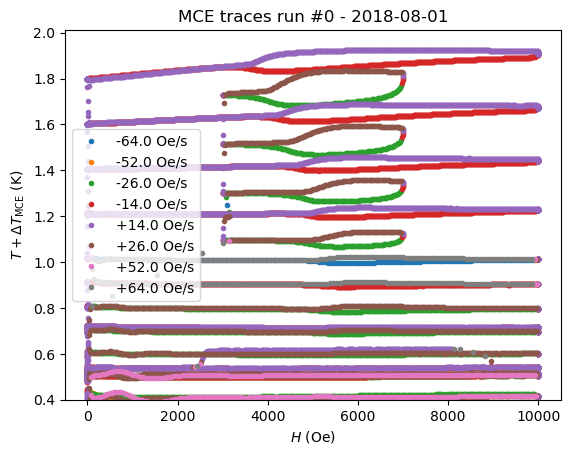

In [72]:
# import ipywidgets as widgets
%matplotlib inline
for runID in runIDs_all:
    fig = plt.figure()
    for i, sr in enumerate(H[runID].columns):
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
    plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'MCE traces run #{runID} - {run_date[runID]}')
    plt.legend()

In [ ]:
sys.path.append(r'C:\Users\Pierre\Desktop\Postdoc\Software\Python\Python_scripts')
import MCE_simulations.mce_no_demag as mce
# mce = reload(mce)# if mce is changed

# Create generator of runIDs, excluding run #6 which is bad
runIDs = [x for x in runIDs_all if x!=6]

In [ ]:
# Identify values of bath temperature used for the measurements
npoints = 250
for runID in runIDs:
    # ut, ct = np.unique(np.round(Tpucki[runID]['raw'], 2), return_counts=True)# Use raw data
    ut, ct = np.unique(np.round(Tpuck[runID], 1), return_counts=True)# Same, by construction of Tpuck[runID]

    # Show counts for each value of bath temperature, ignoring NaN
    print(runID, [[ut[ct>npoints][i], ct[ct>npoints][i]] for i in range(len(ut[ct>npoints]))])
    utbath[runID] = ut[ct>npoints]# select only those values that occur in more than 500 data points
utbath[runID]#

In [ ]:
# Test bath_temp function
sr = sweeprates[runID][0]
for Tb in utbath[runID][:1]:
    dataFilter = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<4e3),
                                np.round(Tpuck[runID][sr], 1)==Tb)
    # print(min(dTp), max(dTp))
    Hp = H[runID][sr][dataFilter]
    Tp = T[runID][sr][dataFilter]
    Tb = mce.bath_temp([Tp], rel_temp_bound=1e-3, timeit=True)
    print(Tb)

### For given field and temperature, find two closest mfd's

In [ ]:
def closest_mfd_values(ptest, upmfd):
    # sort array of fields by distance to current value of field and keep the two closest values
    dpmfd = abs(upmfd-ptest)# 
    closest2p = upmfd[np.argsort(dpmfd)][:2]
    pweights = 1 - dpmfd[np.argsort(dpmfd)][:2]/abs(np.diff(closest2p)[0])

    # if the value of field is below the lowest value in the array or above the highest, 
    # i.e. if the distance between the former and the second closest value in the array is larger than 
    # the distance between the two closest values in the array
    if dpmfd[np.argsort(dpmfd)][1]>=abs(np.diff(closest2p)[0]):
        # only keep the single closest value in the array (i.e. the lowest or the highest)
        closest2p = closest2p[:1]
        pweights = np.ones(1)
        # for instance: if H = 345 and the array is [1000, 2000, 3000], only keep 1000,
        # since abs(2000-345)>abs(2000-1000)
    
    return closest2p, pweights

### Compute second derivative of data

In [ ]:
%matplotlib
pltIDs = [2]
sr = -10
runID = 2
d2Ttest = {}
d2Ttest[sr] = pd.Series(gaussian_filter1d(d1T[runID][sr], 10))
for runID in pltIDs:#runIDs:
    plt.figure()
    plt.plot(H[runID][sr], d1T[runID][sr])
    plt.plot(H[runID][sr], d2Ttest[sr].diff()/dH[runID][sr]*1e2)
#     plt.ylim(bottom=0.4)
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
    plt.ylim(np.arange(-1, 2, 2)*1e-4)
#     plt.legend()

In [ ]:
for elmt in ['d2T', 'd2Tdf', 'HTcd1', 'HTcd2', 'dHc']:
    exec(f'{elmt} = {{}}')

In [ ]:
def data_filter(runID, sr, Tb):
    return np.logical_and(np.logical_and(H[runID][sr]>4e3, H[runID][sr]<5.75e3),
                                         np.round(Tpuck[runID][sr], 1)==Tb)

In [ ]:
for runID in runIDs[:]:
    for elmt in ['d2T', 'd2Tdf', 'HTcd1', 'HTcd2', 'dHc']:
        exec(f'{elmt}[runID] = {{}}')
    for sr in sweeprates[runID][:]:
        for elmt in ['d2Tdf', 'HTcd1', 'HTcd2', 'dHc']:
            exec(f'{elmt}[runID][sr] = {{}}')

        Nsmth = 50/abs(sr)
        d1Tgauss = pd.Series(gaussian_filter1d(d1T[runID][sr], Nsmth))
        d2T[runID][sr] = d1Tgauss.diff()/dH[runID][sr]
        
        for Tb in utbath[runID][:]:
            if Tb==0.4: continue

            dataFilter = np.logical_and(np.logical_and(H[runID][sr]>4e3, H[runID][sr]<5.75e3),
                                        np.round(Tpuck[runID][sr], 1)==Tb)
            Hf = H[runID][sr][dataFilter]
            Tf = T[runID][sr][dataFilter]
            d1Tf = d1T[runID][sr][dataFilter]
            d2Tf = d2T[runID][sr][dataFilter]
            
            try:
                # Save values of critical field; 
                # it seems that .idxmax() is systematically shifted by 1 index 
                # for the 2nd derivative, hence the .idxmax()-1
                HTcd1[runID][sr][Tb] = (Hf[abs(d1Tf).idxmax()], Tf[abs(d1Tf).idxmax()])
                HTcd2[runID][sr][Tb] = (Hf[d2Tf.idxmax()-1], Tf[d2Tf.idxmax()-1])
                dHc[runID][sr][Tb] = Nsmth*abs(sr)*np.sqrt(2*np.log(2))
            except (ValueError, KeyError):
                continue

#         print(HTcd1[runID][sr], HTcd2[runID][sr])
#     d2Tdf[runID] = pd.DataFrame(d2T[runID])

In [ ]:
# Manual corrections to computational errors
for sr in [-14, 14]:
    try:
        del HTcd1[7][sr]
        del HTcd2[7][sr]
    except KeyError:
        continue

runID, sr, Tb = 7, 28, .5
HTcd1[runID][sr][Tb] = (H[runID][sr].loc[535], T[runID][sr].loc[535])

In [ ]:
# Prepare saving figure & data
os.chdir(datFilePath[sample])
savedir = {}
for runID in runIDs:#runIDs:
    dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
    savedir[runID] = f'{dirname}//{this_month}_MCE_fitting//'
    Path(savedir[runID]).mkdir(parents=True, exist_ok=True)
    
header = 'Hc[max(dH/dT)] (Oe), T[Hc[max(dH/dT)]] (K), \
Hc[max(d^2H/dT^2)] (Oe), T[Hc[max(d^2H/dT^2)]] (K)'

In [ ]:
pltIDs = [2]
dlabel = ['1st', '2nd']
darr = {}
# sr = -4
for runID in pltIDs:#runIDs:
    dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
    plt.figure()
    susr = usr[runID][-1:]
    for sr in sweeprates[runID][abs(sweeprates[runID])==susr]:#[-susr, susr]:#
#     plt.plot(H[runID][sr], d1T[runID][sr])
#     plt.plot(H[runID][sr], d2T[runID][sr]*1e2)
#     plt.ylim(np.arange(-1, 2, 2)*1e-4)
        plt.plot(H[runID][sr], T[runID][sr], '.', label=f'{sr:+.1f} Oe/s')
        for elidx, elmt in enumerate(['dHc', 'HTcd1', 'HTcd2']):
            darr[elmt] = np.asarray(list(eval(f'{elmt}[runID][sr].values()')))
#         pltHTcd2 = np.asarray(list(HTcd2[runID][sr].values()))
            if elidx>0:
                plt.errorbar(darr[elmt][:,0], darr[elmt][:,1], xerr=darr['dHc'], ls='', lw=2,
                             marker='*', ms=9, label=f'max {dlabel[elidx-1]} der.')
#         plt.plot(darr['HTcd2'][:,0], darr['HTcd2'][:,1], marker='*', ms=9, label='max 2nd der.')
#         plt.ylim(bottom=.4)
        plt.xlabel(xlabel_mce)
        plt.ylabel(ylabel_mce)
        plt.title(f'Smoothed MCE traces run #{runID} - {run_date[runID]}')
        plt.legend(loc='upper left')
        
        # Save data
#         saveHcData = f'{savedir[runID]}{str(today)}_run{runID}_sweeprate{int(sr):+d}Oeps_Hc'
#         data = np.vstack([pltHTcd1[:,0]*rescaling, pltHTcd1[:,1],
#                           pltHTcd2[:,0]*rescaling, pltHTcd2[:,1]]).T
#         np.savetxt(f'{saveHcData}.csv', data, fmt='%.3e', delimiter=',', header=header)

In [ ]:
# saveHcFig = f'{savedir[runID]}{str(today)}_run{runID}_sweeprate+-{int(susr)}Oeps_Hc'
# plt.savefig(f'{saveHcname}.png', dpi=300)

### Create dataframe containing all values of critical field 
as extracted from both the first and second derivatives of the MCE data

In [ ]:
HTcdf = {}

for runID in HTcd1.keys():
    HTcdf[runID] = {}
    for sr in HTcd1[runID].keys():
        # Create a dataframe for each value of sweeprate in a given run
        for Tb in HTcd1[runID][sr].keys():
            HTcdf[runID][sr] = pd.concat([pd.DataFrame(HTcd1[runID][sr]).T, 
                                          pd.DataFrame(HTcd2[runID][sr]).T,
                                          pd.Series(dHc[runID][sr])], axis=1)
            HTcdf[runID][sr].columns = ['Hcd1_raw', 'Tcd1', 'Hcd2_raw', 'Tcd2', 'dHc']
#             HTcdf[runID][sr]['dHc'] = abs(HTcdf[runID][sr]['Hcd1']-HTcdf[runID][sr]['Hcd2_raw'])
            HTcdf[runID][sr]['Sweeprate'] = sr
            HTcdf[runID][sr]['Run #'] = runID
            HTcdf[runID][sr]['Date'] = run_date[runID]
            HTcdf[runID][sr].reset_index(inplace=True)
            HTcdf[runID][sr].rename(columns={'index':'Tbath'}, inplace=True)
    
    # For a given run, concatenate dataframes at all sweeprates together
    HTcdf[runID]['all'] = pd.concat([HTcdf[runID][sr] for sr in HTcdf[runID].keys()], ignore_index=True)

# Concatenate dataframes of all runs together
HTcdf['all'] = pd.concat([HTcdf[runID]['all'] for runID in HTcdf.keys()], ignore_index=True)

# Rescale values of critical field measured when sweeping field downwards
for der_idx in range(1,3):
    HTcdf['all'][f'Hcd{der_idx}'] = np.where(HTcdf['all']['Sweeprate']<0, 
                                             HTcdf['all'][f'Hcd{der_idx}_raw']*rescaling, 
                                             HTcdf['all'][f'Hcd{der_idx}_raw'])

# Rearrange columns 
cols = HTcdf['all'].columns.tolist()
cols = cols[:2] + cols[-2:-1] + cols[2:4] + cols[-1:] + cols[4:-2]
HTcdf['all'] = HTcdf['all'][cols]

In [ ]:
#### Plot critical field at each temperature vs sweeprate
Hc_sel = {}
xhc = {}
dyhc = {}
yhc = {}

# %matplotlib 
plt.figure()
for Tb in np.unique(HTcdf['all']['Tbath'])[:]:
    # Hc_sel['upsweep'] = np.logical_and(HTcdf['all']['Tbath']==Tb, HTcdf['all']['Sweeprate']>0)
    # Hc_sel['downsweep'] = np.logical_and(HTcdf['all']['Tbath']==Tb, HTcdf['all']['Sweeprate']<0)
    Hc_sel['upsweep'] = HTcdf['all']['Tbath']==Tb

    for sweep in ['upsweep']:
        xhc[sweep] = HTcdf['all'][Hc_sel[sweep]]['Sweeprate']
        yhc[sweep] = HTcdf['all'][Hc_sel[sweep]]['Hcd2']
        dyhc[sweep] = HTcdf['all'][Hc_sel[sweep]]['dHc']

    plt.errorbar(xhc['upsweep'], yhc['upsweep'], yerr=dyhc['upsweep'], fmt='.', label=f'{Tb}')
    # plt.errorbar(xhc['upsweep'], HTcdf['all'][Hc_sel[sweep]]['Hcd2_raw'], yerr=dyhc['upsweep'], fmt='.')
    # plt.errorbar(xhc['downsweep'], yhc['downsweep'], yerr=dyhc['downsweep'], fmt='.')
    plt.legend(loc='lower left', ncol=2, title='$T_\mathrm{{bath}}$ (K)')
    plt.xlabel('Sweeprate (Oe/s)')
    plt.ylabel('Critical field (Oe)')

In [ ]:
# Export dataframe to csv file
saveHcData = f'./Extracted_critical_fields/{str(today)}_Hc_all_runs.csv'
# HTcdf['all'].to_csv(saveHcData, index=False)

In [ ]:
# Insert string of units in 2nd line of csv file
Hc_units = 'K,Oe,Oe,K,Oe,Oe,K,Oe,Oe/s,,\n'# units corresponding to HTcdf['all'].columns
try:
    with open(saveHcData, 'r+') as f:
        contents = f.readlines()# store file contents
        contents.insert(1, Hc_units)# insert string between first and second lines
        f.seek(0)# reset cursor to begining of file
    #     f.writelines(contents)# rewrite file with new contents
except FileNotFoundError:
    pass

To do as of 2021-01-28:
* Fit with Rafael's predictions
* Repeat for sample measured in DR
    
Notes:
* For the case of the 'needle-shaped samples, simulated curves have their upturns coincide with those of the data when determining Hc from second derivatives of MCE data, both for up- and downsweep; confirm with data on sample measured in DR
* After rescaling Hc(downsweep) with mean(Hin/Hext), the critical fields of the up- and downsweeps agree well at all temperatures

### Simulate MCE curves

In [ ]:
# Callback function for debugging
def iter_callback(params, iter_num, resid, H, data=None, trace=None):
    print(iter_num, params['ODE_prefactor'].value)
    
class FakeLMFitResult:
    """
    Dummy class that has an attribute 'params', similar to the result of a fit with lmfit.
    """
    def __init__(self, params):
        self.params = params

#### Function to compute variables required to simulate MCE curves

In [ ]:
def xfit_mce(H, T, Tpuck, Tb, htcd1, htcd2, fitRange, mfd, srpm, us, utmfd, fit=False):
    d = {}
    Hc = {}
    for elmt in ['Hc', 'Hf', 'Tf', 'Hffit', 'Tffit', 'Tbath', 'prms', 'trace_str']:
        exec(f'{elmt} = []', d)
    for idx, sr in enumerate(srpm):#
        # select data to analyze; note: solve_ivp fails for H<1 Oe (H/Hc0<2e-3)
        dataFilter = np.logical_and(np.logical_and(H[sr]>10, H[sr]<9.99e3),
                                    np.round(Tpuck[sr], 1)==Tb)
        if len(T[sr][dataFilter])<100: continue
        d['Hf'].append(H[sr][dataFilter])
        d['Tf'].append(T[sr][dataFilter])
        d['Tbath'].append(mce.bath_temp([d['Tf'][-1][d['Hf'][-1]<4e3]]))
        if d['Tbath'] is None: continue
        Hf_filter = np.logical_and(d['Hf'][-1]>fitRange[0], d['Hf'][-1]<fitRange[1])
        d['Hffit'].append(d['Hf'][-1][Hf_filter])
        d['Tffit'].append(d['Tf'][-1][Hf_filter])
        if len(d['Hffit'][-1])<50: continue
        if sr>0: 
            d['trace_str'].append('upsweep')
            Hc[sr] = htcd2[sr][Tb][0]
        else: 
            d['trace_str'].append('downsweep')
            Hc[sr] = htcd2[sr][Tb][0]

        
    if len(d['Hf'])==0: return None
    Tbm = np.mean(d['Tbath'])
    # Find MFD with temperature closest to Tbath
    Tbmfd, _ = closest_mfd_values(Tbm, utmfd)
    Hc0 = 5e3
    mfd_key = (Hc0, Tbmfd[0])
    # Compute the number of datapoints in the range of the corresponding mfd
    hnpoints = abs(abs(d['Hf'][0]/Hc0-1).idxmin() - abs(d['Hf'][0]/Hc0-(1-mfd[mfd_key]['rel_width'])).idxmin())
    # Compute the corresponding histogram
    mfd[mfd_key]['hc'], _, _ = mfd_histogram(mfd[mfd_key]['data'], 
                                             mfd_key[0], nbins=hnpoints)

    for idx, sr in enumerate(srpm):#
        # Define fit parameters
        d['prms'].append(mce.mce_parameters(Hc=Hc[sr], sweeprate=us, 
                                            kappa=.05*np.sqrt(Tbm), 
                                            Tc0=2.2, Tbath=Tbm))
    if fit is True:
        out = minimize(mce.xmce_residual, d['prms'][-1], method='least_squares',
                       args=(d['Hffit'], d['Tffit'], d['trace_str']),
                       kws={'mfd_hc':mfd[mfd_key]['hc'], 'Tbath':d['Tbath']}, 
                       iter_cb=None)#, **{'ftol':1e-15})#, max_nfev=100)#)
    else:
        out = None
    
    return d['Hf'], d['Tf'], d['trace_str'], mfd_key, out, d['prms']

In [ ]:
# import ipywidgets as widgets
# %matplotlib 
runID = 2
for dico in [mce_fit, mce_sim]:
    if runID not in dico.keys():
        dico[runID] = {}

dirname = [s for s in next(os.walk('.'))[1] if f'Run{runID}' in s][0]
fitRange = {2:[4e3, 9e3], 3:[4e3, 6e3], 4:[4e3, 6e3], 5:[4e3, 8e3], 7:[4e3, 6.3e3]}
# prm_rng = {2:(range(0,3,2), range(1,len(utbath[2]))), 3:None}

for us in usr[runID][-1:]:
    lgd_labels = []
    plt.figure(num=int(us))
    srpm = sweeprates[runID][abs(sweeprates[runID])==us]
    for Tb in utbath[runID][1:]:
        result = xfit_mce(H[runID], T[runID], Tpuck[runID], Tb, HTcd1[runID], HTcd2[runID],
                          fitRange[runID], mfd, srpm, us, utmfd, fit=False)
        if result is None: continue
        Hf, Tf, strace, mfd_key, out, prms = result
#         if out is not None:
#             mce_fit[runID][us] = out

        for idx, sr in enumerate(srpm):#
            if out is None:
                out = FakeLMFitResult(prms[idx])
                print(f'{sr:+.0f} Oe/s\t Tb = {Tb} K\t Hc = {out.params["Hc"].value:.0f} Oe\
                ODE prefactor = {out.params["ODE_prefactor"].value:.3f}')
                
            mce_sim[runID][sr] = mce.mce_residual(out.params, Hf[idx], data=None, 
                                                  trace=strace[idx], mfd_hc=mfd[mfd_key]['hc'])
            srlabel = f'{sr:+.0f} Oe/s'
            out = None

            # Plot results
            plt.plot(Hf[idx], Tf[idx], '.', color=f'C{idx}', markersize=2,
                     label=f'data {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
        #     plt.plot(Hf, mce_sim[sr], '-', color=f'C{idx}', label=f'fit {sr:+.1f} Oe/s')
            # Plotting the fit with sorted arguments avoids lines connecting low and high Hf values
            cutoff = 20
            plt.plot(Hf[idx][:-cutoff].sort_values(), mce_sim[runID][sr][Hf[idx][:-cutoff].argsort()], 
                     '-', linewidth=1, color=f'C{idx}',
                     label=f'fit {srlabel}' if srlabel not in lgd_labels else '_nolegend_')
            # Keep track of legend labels to avoid duplicates
            if srlabel not in lgd_labels:
                lgd_labels.append(srlabel)
    plt.title(f'MCE traces run #{runID} - {run_date[runID]}\n\
    Up- and downsweep fits constrained together and include MFD')
    plt.xlabel(xlabel_mce)
    plt.ylabel(ylabel_mce)
    plt.legend(loc='upper left')
    
    # Save figure
    savefitname = f'{dirname}//{this_month}_MCE_fitting//\
{str(today)}_run{runID}_sweeprate+-{int(us)}Oeps_+fits_noMFD.png'
#     plt.savefig(savefitname, dpi=300)
cursor()

In [ ]:
savefitname
plt.savefig(savefitname, dpi=300)

## Include Comsol MFD in MCE fits
This section is for tests.
Outdated as of 2021-01-28.

### Test computation of MCE curve convolved with MFD

In [ ]:
runID = 2
sr = 10
Tb = 1.0
dataSel = np.logical_and(np.logical_and(H[runID][sr]>10, H[runID][sr]<9.99e3),
                         np.round(Tpuck[runID][sr], 1)==Tb)
Hf = H[runID][sr][dataSel]
Tf = T[runID][sr][dataSel]

In [ ]:
Ttest = Tb
closest2T, Tweights = closest_mfd_values(Ttest, utmfd)
print(Ttest, closest2T, Tweights)
Htest = Hf[200]
closest2H, Hweights = closest_mfd_values(Htest, uhext)
print(Htest, closest2H, Hweights)

In [ ]:
# Update mfd_key with the closest temperature
mfd_key = (5e3, closest2T[0])

# Compute the number of datapoints in the range of the corresponding mfd
hnpoints = abs(Hf/Hc-1).idxmin() - abs(Hf/Hc-(1-mfd[mfd_key]['rel_width'])).idxmin()

# Compute the corresponding histogram
mfd[mfd_key]['hc'], mfd[mfd_key]['binCenters'], mfd[mfd_key]['binWidths'] = \
mfd_histogram(mfd[mfd_key]['data'], Hext, nbins=hnpoints)

In [ ]:
prms = mce.mce_parameters(Hc0=Hc0, sweeprate=-sr, Tc0=Tc0, Tbath=Tb)
Tcalc = mce.mce_residual(prms, Hf, trace='downsweep')
Tcalc[int(len(Tcalc)/2)-50:int(len(Tcalc)/2)+50]

In [ ]:
from scipy.signal import convolve
# Update mfd_key to use the mfd closest to the critical field (H ~ 5 kOe)
Tout = convolve(Tcalc, mfd[mfd_key]['hc'], mode='same')/sum(mfd[mfd_key]['hc'])
# Check that the convolution acts on a wide enough range of magnetic fields. 
# Might require some kind of adaptability of its width...
# At the very least, make sure the width is correct around the critical field
Tout[int(len(Tout)/2)-50:int(len(Tout)/2)+50]

In [ ]:
# Plot convolution of magnetic field with MFD
# fig, ax = plt.subplots()
plt.plot(Hf, Tcalc)
plt.plot(Hf, Tout)
cursor()